##### **6 학습 관련 기술들**
https://github.com/WegraLee/deep-learning-from-scratch

https://sdr1982.tistory.com/201#google_vignette

---



**Optimization**
- Loss를 최소화 하는 파라미터 값을 찾는 작업 

---

##### **Optimizer**
- Gradient를 사용하여 파라미터를 '어떻게' 수정할지 결정하는 알고리즘

**SGD**
- 가장 기본이 되는 optimzer
- 1개의 데이터
    - Gradient descent(전체 데이터)
    - Mini-batch SGD (일부 데이터)
- 요동치는경향이 있음

**AdaGrad**
- 학습을 진행하면서 학습률을 점차 줄여가는 방법

**Momentum**
- SGD + 관성
- 이전 step의 움직임을 일정 비율 유지함
    - 진동을 줄이고 더 빠르게 수렴하도록 돕는 기법


**RMSProp**
- Gradient의 크기를 제곱으로 분모에 누적함 
    - gradient가 크면 업데이트 폭이 작아져 너무 가파르게 내려가지않고 다른 minimum을 탐색하도록 하기 위해

**ADAM = RMSprop + Momentum**
- 학습 빠르고 안정적, 대부분 모델 기본값

---

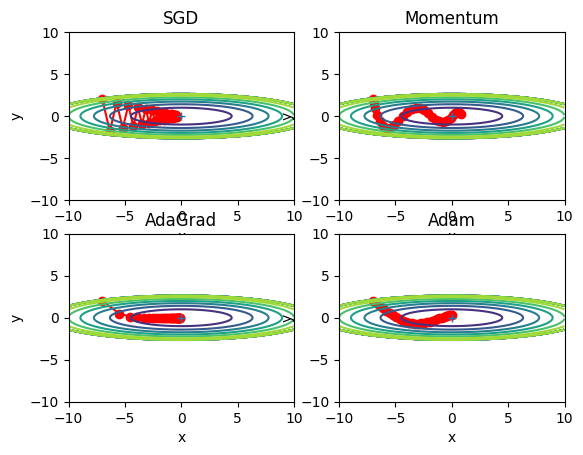

In [2]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/optimizer_compare_naive.py 참고
# coding: utf-8

import sys, os
sys.path.append(os.pardir)  
from common.optimizer import SGD, Momentum, AdaGrad, Adam

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

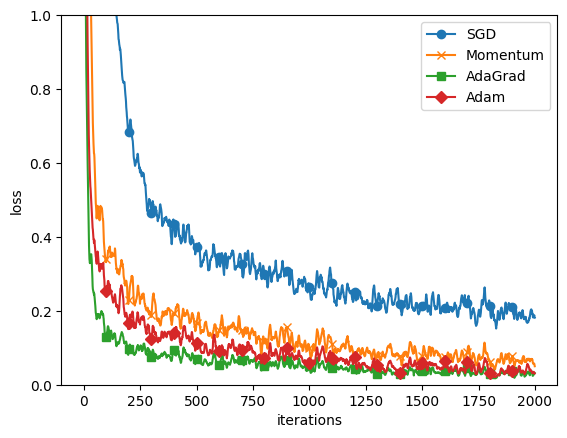

In [ ]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
#from common.optimizer import *

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        #print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            #print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

--- 

**가중치의 초기값**

- **가중치 초기값을 0이나 동일한 값으로 설정시 모든 뉴런이 똑같은 동작**을 하게 됨 (기울기가 같으므로)

**은닉층의 활성화 값 분포**




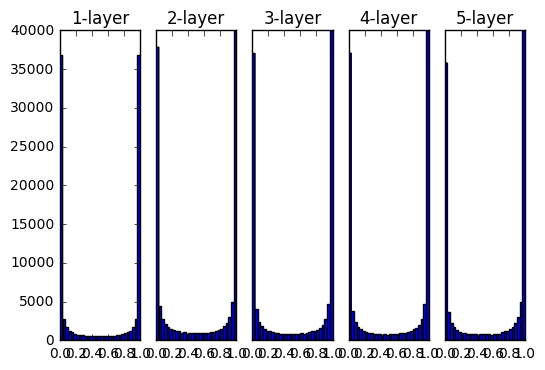

In [8]:
from IPython.display import Image, display
display(Image(filename='images/1.png', embed=True))


위 사진은 표준편차가 1인 정규분포*(-3~3에 분포)*를 사용했을때 <br> 
각 층의 활성화 값들이 0과 1에 치우쳐 분포되어 있다.

이러한 현상을 Gradient vanishing이라고 하는데,데이터가 0과 1에 치우치게 되면 역전파의 기울기값이 점점 작아지다가 사라짐 (업데이트가 거의 일어나지않음) <br>
**ReLU를 통해 극복 가능하다.**

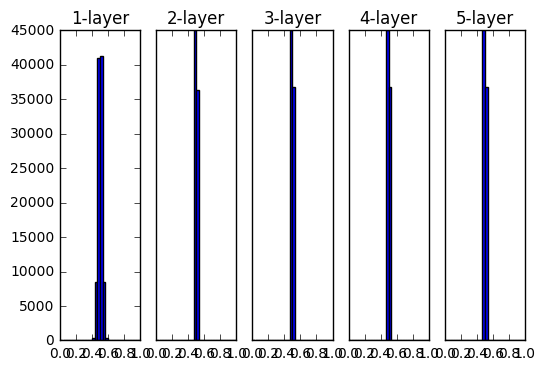

In [6]:
from IPython.display import Image, display
display(Image(filename='images/2.png', embed=True))


위 사진은 표준편차를 0.01로 *(-0.03~0.03에 분포)* 줬을때이다.
<br> 대부분이 0.5의 값을 출력하고 있는데 이는 깊은 신경망을 구성했지만 대부분의 노드가 같은 출력을 하고 있다는 뜻으로 표현력이 제한된다.

즉 너무 멀리퍼지면(표준편차 1) 신호가 다 죽고, <br>
너무 안퍼지면(0.01) 다 똑같은 표현만 한다.

---

**Xavier(사비에르) 초기값 (Linear, sigmoid, tanh)**
($\frac{1}{\sqrt{n}}$)
- 앞 층의 노드 수($n$)에 따라 가중치의 범위를 유동적으로 조절
- activation function이 linear, sigmoid, tanh 할때 전제

---

**He 초기값 ($\sqrt{\frac{2}{n}}$)**

- ReLU를 activation function으로 사용할때 사용
- 데이터가 반토막 나는 것을 보상하기 위해, Xavier보다 가중치를 더 넓게(약 $\sqrt{2}$배)

---

**Batch Normalization**

- 각 층이 활성화를 적당히 퍼뜨리도록 `강제`
    - 학습 속도 ↑
    - 초기값 의존 ↓
    - overfitting ↓

- 학습 과정에서 미니배치(Batch) 단위로 데이터의 평균을 0, 분산을 1이 되도록 정규화

다시 말해서, batch 별로 정규화를 시킨다.  <br>
100개씩 10묶음(10 batch)이면 각 묶음내의 데이터 100개에 대해서만 정규화


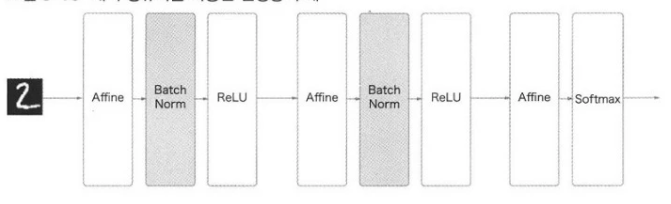

In [9]:
from IPython.display import Image, display
display(Image(filename='images/3.png', embed=True))


Affine(가중치 곱) → Batch Norm(정규화) → Activation(ReLU 등)

---

**overfitting**

- 모델이 훈련 데이터에 과도하게 적합되어 훈련 데이터에는 성능이 좋게 나오지만 새로운 데이터(test)에 대한 일반화 성능이 떨어지는 현상

- 이를 방지하기 위해   Early Stopping, Data Augmentation, Dropout, Regularization, Batch Normalization 등을 사용함.


- 주로 발생하는 경우
    - 파라미터가 많은 모델
    - 훈련 데이터가 적음

---
**weight decay** <br>
L1, L2 Regularization을 의미

Regularization은 기존 Loss에 weight의 크기를 고려하여 모델의 복잡도를 줄이고 overfitting을 방지하는 방법입니다.  

L1 은 가중치의 절댓값을 사용하여, **모든 weight에 동일한 비율로 제약**을 주기 때문에 일부weight가 0으로 수렴해 불필요한 연결을 제거하는 효과가 있습니다. 

반면 L2는 가중치 크기의 제곱을 사용해, **가중치가 클수록 더 강하게 제약**을 줘서 전체적으로 weight가 균형 있게 작아지는 효과를 냅니다. 이를 통해 안정적이고 일반화 성능이 높은 모델을 만들 수 있습니다.

L2는 제곱이지만 gradient에서 미분시 2W가 되므로 비례
L1은 절대값이지만 미분시 +-1이 되므로 똑같은 효과

---

**Early Stopping** <br>
Early Stopping은 Validation Loss를 기준으로 가장 성능이 좋은 시점의 모델을 저장하고 학습을 멈추는 것.

(Validation set은 학습 과정에서 모델의 성능을 검증하고 하이퍼파라미터를 조정하기 위한 데이터입니다. 반면 Test set은 학습이 모두 끝난 후, 모델의 최종 일반화 성능을 평가하기 위해 한 번만 사용됩니다.)

---

**Data Argumentation** <br>
기존 훈련 데이터를 변형하거나 조합해서 새로운 데이터를 인위적으로 만들어내는 기법입니다. 이미지로 예를 들면 채도, 휘도 변경 또는 분할, 회전이 하여 증강하는 방법이 있습니다.

---

**Dropout** <br>
Dropout은 학습 과정에서 일부 노드를 확률적으로 비활성화하여 특정 노드나 경로에 대한 의존을 줄이는 정규화 기법입니다. 이를 통해 오버피팅을 방지하고, 마치 여러 신경망을 합 것과 같은 일반화 효과를 얻을 수 있습니다.

(Loss를 구할때 특정노드를 dropout시키고 구함. )

→ 특정 노드가 잘하면 거기에 집중되고 나머지 노드는 놀게됨.

이를 방지하기 위해 랜덤하게 노드를 죽이면서 각 노드가 데이터에 대해 특징을 모두 잘 뽑을 수 있도록 하는것.

---

**ensemble learning(앙상블 학습)**

개별적으로 학습된 여러개의 모델의 출력을 평균을 내어 추론함.

dropout과 비슷한 메커니즘

---
---

**하이퍼파라미터 최적화**

- 하이퍼파라미터
    - 각 층의 노드 수, 배치크기, 학습률 등
- 이 하이퍼파라미터를 평가하기 위한 지표로 validation data를 사용한다.

베이즈 최적화(Bayesian optimization)
- 이전 실험 결과들을 바탕으로 "어떤 구간에서 성능이 잘 나올지"를 확률적으로 예측하며 똑똑하게 찾아가는 방식
    - `Optuna`나 `Ray Tune` 같은 라이브러리가 이 방식